<a href="https://colab.research.google.com/github/pszachew/withdrawal-prediction/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date

In [4]:
data = pd.read_csv("/content/gdrive/MyDrive/euronet/Dane_zadanie1.csv", sep=";")

In [5]:
def preprocessing(data: pd.DataFrame) -> pd.DataFrame:
  data['ProcessDate'] = pd.to_datetime(data['ProcessDate'])
  seasons = {1:"Winter", 2:"Spring", 3:"Summer", 4:"Autumn"}
  ls=['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday', 'sunday']
  data["weekday"] = data["ProcessDate"].apply(lambda x: ls[x.weekday()])
  data["season"] = data["ProcessDate"].apply(lambda x: seasons[x.month%12 // 3 + 1])
  return data

In [38]:
data = preprocessing(data)
data[data["Atm"]=="ATM1"]['ProcessDate']

0     2017-01-02
1     2017-01-03
2     2017-01-04
3     2017-01-05
4     2017-01-07
         ...    
878   2019-10-26
879   2019-10-28
880   2019-10-29
881   2019-10-30
882   2019-10-31
Name: ProcessDate, Length: 883, dtype: datetime64[ns]

In [7]:
data.dtypes

Atm                    object
ProcessDate    datetime64[ns]
Withdrawal              int64
weekday                object
season                 object
dtype: object

In [8]:
data.isna().sum()

Atm            0
ProcessDate    0
Withdrawal     0
weekday        0
season         0
dtype: int64

In [9]:
def create_lineplot(atm: str, data: pd.DataFrame):
  tmp = data[data['Atm'] == atm]
  plt.figure(figsize=(12,8))
  sns.lineplot(x="ProcessDate", y="Withdrawal", data=tmp, hue="season")
  plt.title(atm)
  plt.show()

In [10]:
def create_histplot(atm: str, data: pd.DataFrame):
  tmp = data[data['Atm'] == atm]
  plt.figure(figsize=(12,8))
  sns.histplot(x="Withdrawal", data=tmp, hue="season", element="poly")
  plt.title(atm)
  plt.show()

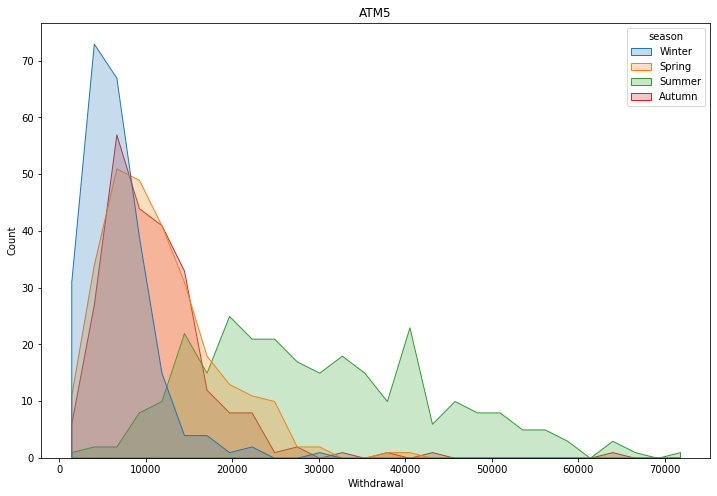

In [ ]:
create_histplot("ATM5", data)

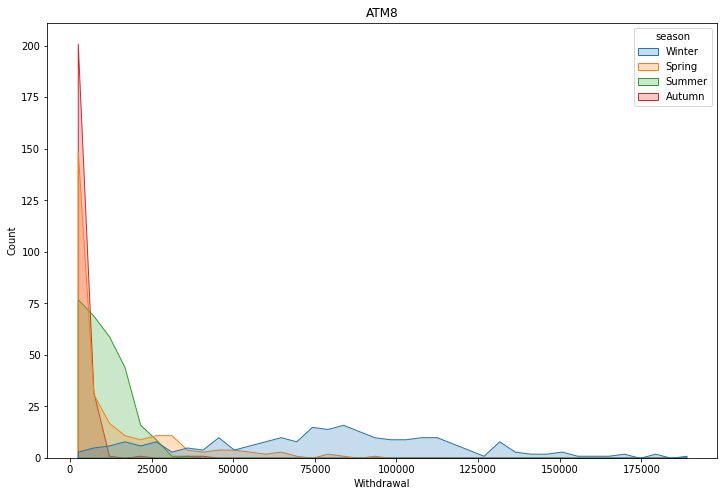

In [ ]:
create_histplot("ATM8", data)

## **EDA**

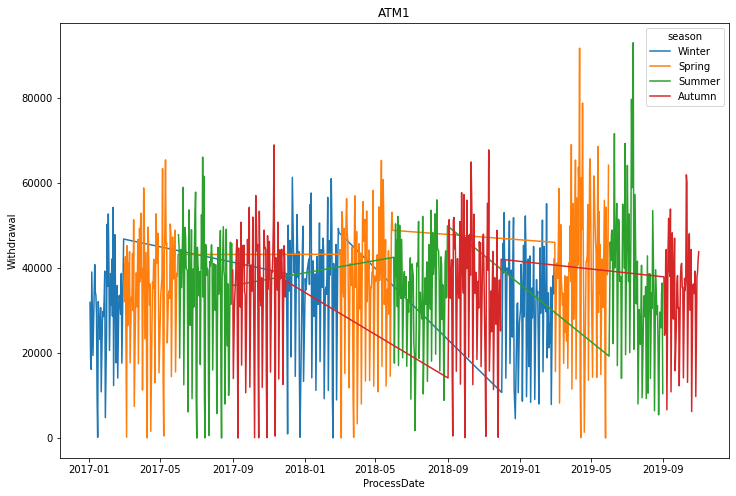

In [ ]:
create_lineplot("ATM1", data)

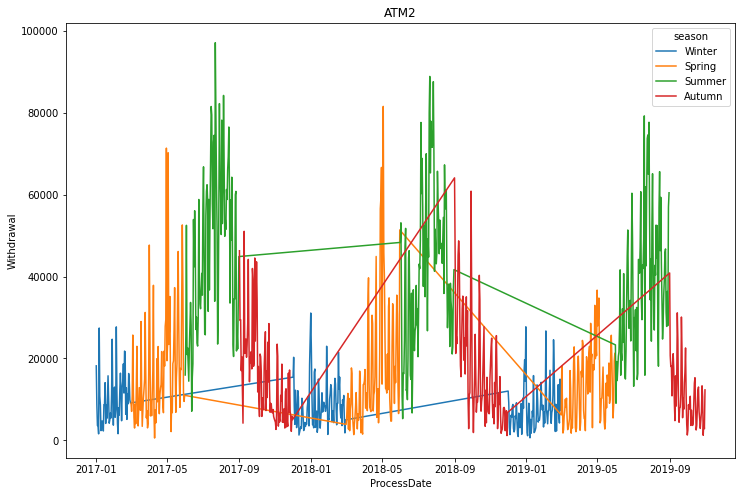

In [ ]:
create_lineplot("ATM2", data)

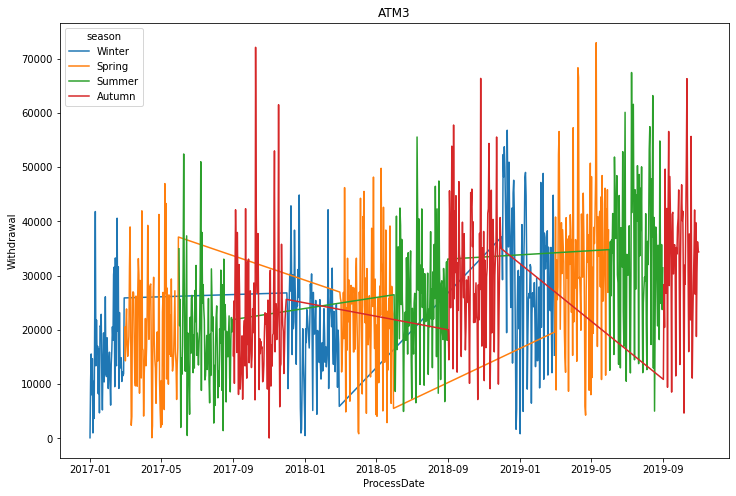

In [ ]:
create_lineplot("ATM3", data)

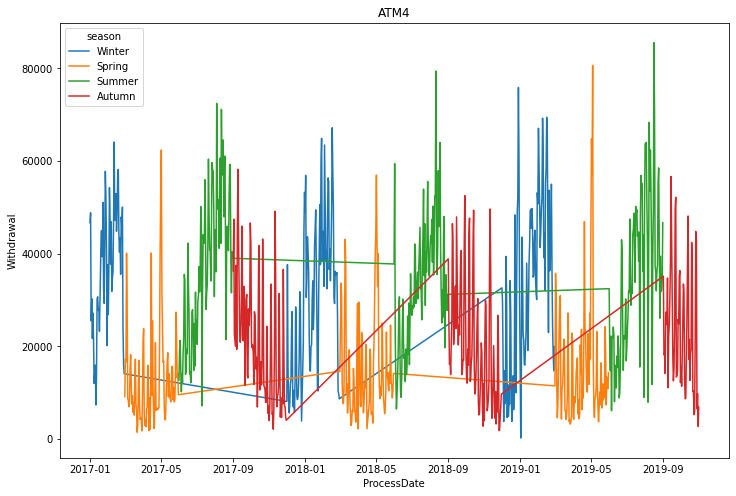

In [ ]:
create_lineplot("ATM4", data)

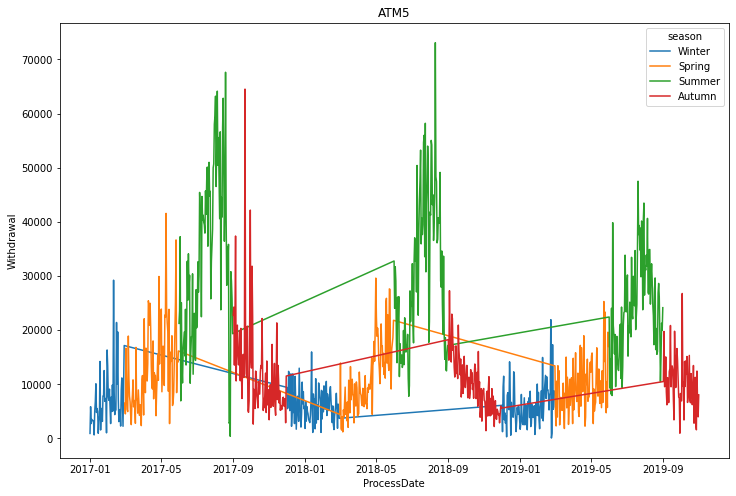

In [ ]:
create_lineplot("ATM5", data)

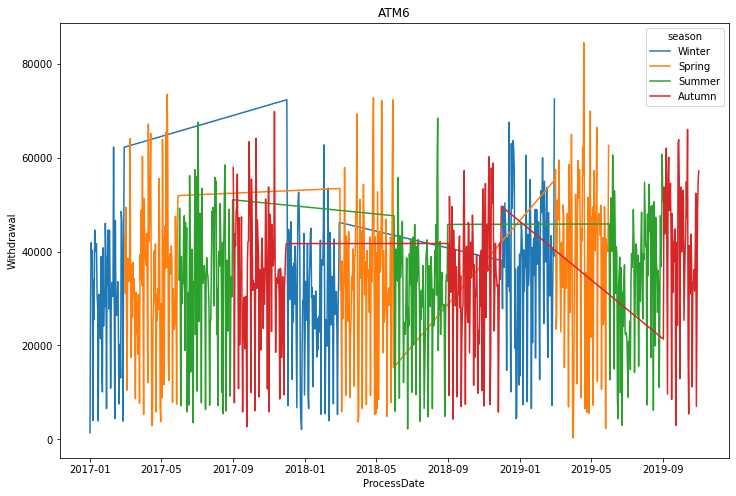

In [ ]:
create_lineplot("ATM6", data)

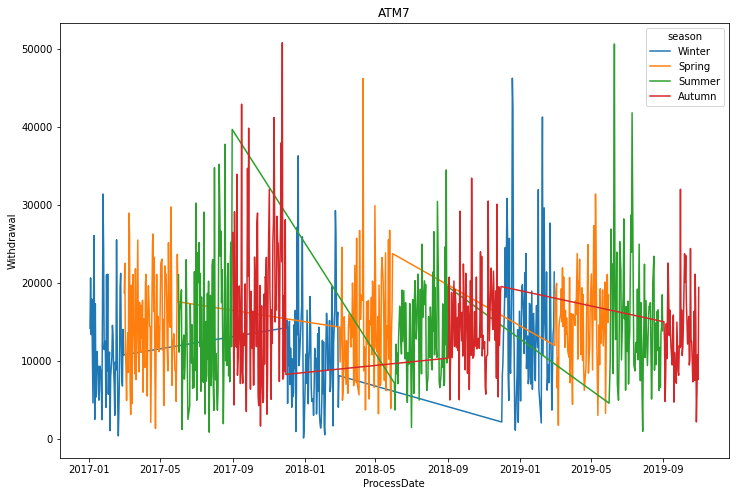

In [ ]:
create_lineplot("ATM7", data)

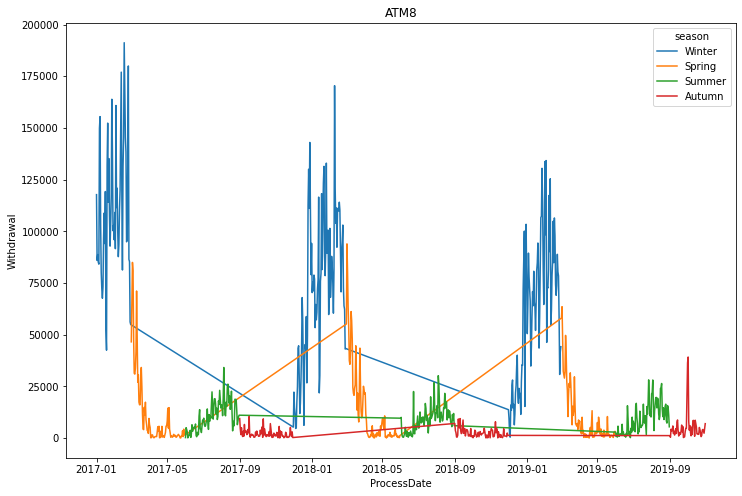

In [ ]:
create_lineplot("ATM8", data)

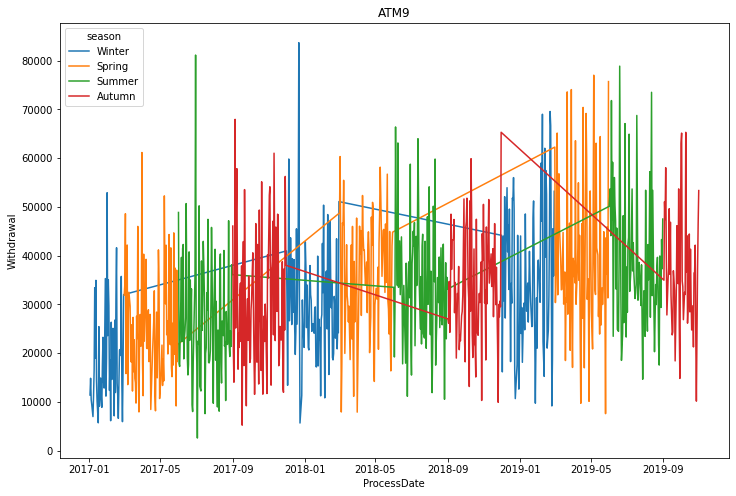

In [ ]:
create_lineplot("ATM9", data)

**Wnioski:**
Analizując powyższe wykresy można zauważyć, że pora roku jest dobrą zmienną decyzyjną - niektóre bankomaty znajdują się w miejscowościach turystycznych typowo letnich i w wakacje jest większe zapotrzebowanie na gotówkę (np ATM2, ATM5), lecz jest też taki, który może znajdować się np. przy stoku narciarskim (ATM8). Ostatecznie jako zmienne decyzyjne do modelu wzięta będzie pora roku oraz dzień tygodnia. Dla każdego z bankomatów zbuduję oddzielny model - można to również zrobić przekształcając zadanie w zadanie klasyfikacji wieloetykitowalej (ang. multilabel classification), że do każdego wektora przypisane jest 9 etykiet oznaczającyh kwotę.

In [16]:
def split_data(atm: str, data: pd.DataFrame):
  final_frame = pd.get_dummies(data=data, columns=["weekday", "season"], drop_first=True)
  tmp = final_frame[data['Atm'] == atm]
  X_train, y_train = tmp[0:-30], tmp[0:-30]['Withdrawal']
  X_test, y_test = tmp[-30:], tmp[-30:]['Withdrawal']
  X_train = X_train.drop(columns=["Atm","ProcessDate","Withdrawal"])
  X_test = X_test.drop(columns=["Atm","ProcessDate","Withdrawal"])
  X_train.columns=['monday','saturday','sunday', 'thursday', 'tuesday', 'wednesday', 'Spring', 'Summer', 'Winter']
  X_test.columns=['monday','saturday','sunday', 'thursday', 'tuesday', 'wednesday', 'Spring', 'Summer', 'Winter']
  return X_train, X_test, y_train, y_test

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [61]:
def build_model(atm: str, data: pd.DataFrame):
  X_train, X_test, y_train, y_test = split_data(atm, data)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_predicted = model.predict(X_test)
  print(f"Metrics for {atm}")
  print(f"RMSE on test data {np.sqrt(mean_squared_error(y_test, y_predicted))}")
  print(f"RMSE on train data {np.sqrt(mean_squared_error(y_train, model.predict(X_train)))}")


  datelist = pd.DataFrame(pd.date_range(date.fromisoformat("2019-11-01"), periods=60).to_pydatetime().tolist(), columns=["ProcessDate"])
  seasons = {1:"Winter", 2:"Spring", 3:"Summer", 4:"Autumn"}
  ls=['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday', 'sunday']
  datelist["weekday"] = datelist["ProcessDate"].apply(lambda x: ls[x.weekday()])
  datelist["season"] = datelist["ProcessDate"].apply(lambda x: seasons[x.month%12 // 3 + 1])
  weekday_dum = pd.get_dummies(datelist["weekday"])
  season_dict = {"Autumn":[], "Spring":[], "Summer":[], "Winter":[]}
  for dt in datelist["ProcessDate"]:
    season_idx = dt.month%12 // 3 + 1
    season_dict[seasons[season_idx]].append(1)
    for j in range(1,5):
      if j != season_idx:
        season_dict[seasons[j]].append(0)
  season_dum = pd.DataFrame(season_dict)
  season_dum = season_dum.drop(columns="Autumn")
  fin = pd.concat([season_dum, weekday_dum], axis=1)
  fin = fin[['monday','saturday','sunday', 'thursday', 'tuesday', 'wednesday', 'Spring', 'Summer', 'Winter']]
  next = model.predict(fin)
  pred_frame = pd.DataFrame(pd.date_range(date.fromisoformat("2019-11-01"), periods=60).to_pydatetime().tolist(), columns=["ProcessDate"])
  pred_frame["Withdrawal"] = next
  pred_frame['type'] = "predicted"
  

  hist_frame = data[data["Atm"]==atm][["ProcessDate","Withdrawal"]]
  hist_frame['type'] = "historical"
  all = pd.concat([hist_frame, pred_frame], axis=0)
  all = all.set_index("ProcessDate")
  plt.figure(figsize=(12,8))
  plt.title(atm)
  sns.lineplot(x="ProcessDate", y="Withdrawal", hue="type", data=all)
  plt.show()

Metrics for ATM1
RMSE on test data 7360.678980603539
RMSE on train data 8783.061338178039


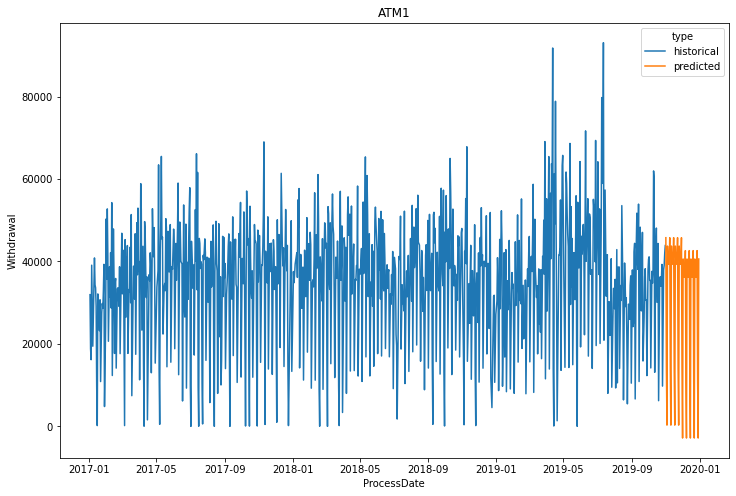

Metrics for ATM2
RMSE on test data 10101.984780000384
RMSE on train data 12170.141447467704


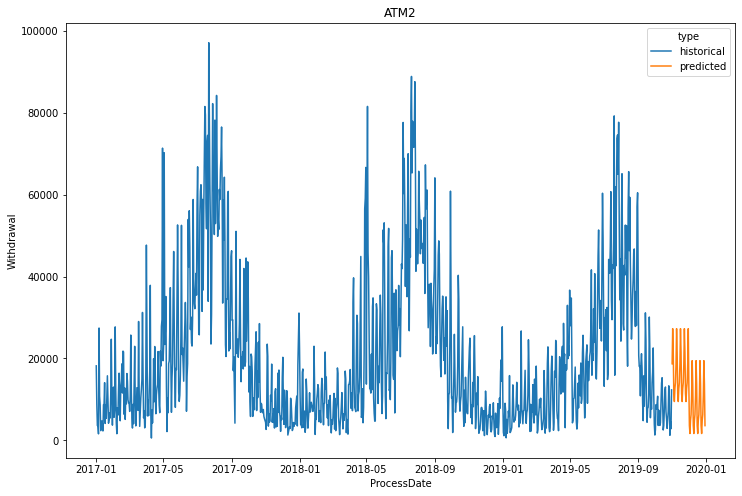

Metrics for ATM3
RMSE on test data 11738.74143025323
RMSE on train data 11039.730466563155


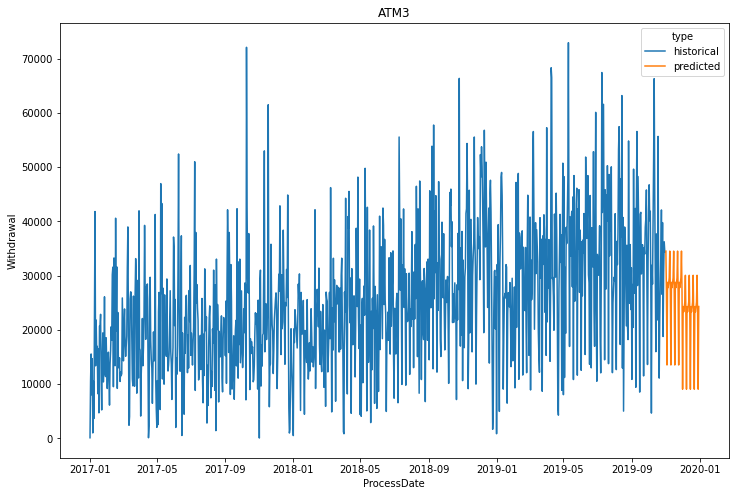

Metrics for ATM4
RMSE on test data 8731.765485107748
RMSE on train data 12939.797553268676


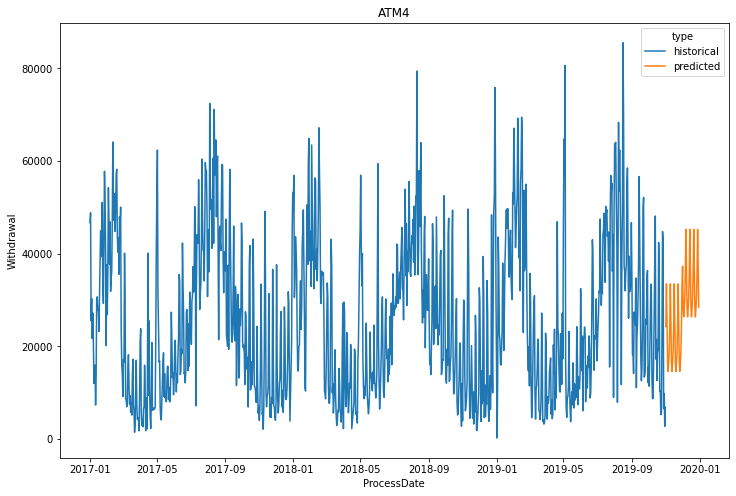

Metrics for ATM5
RMSE on test data 4983.788112549688
RMSE on train data 8633.069310207125


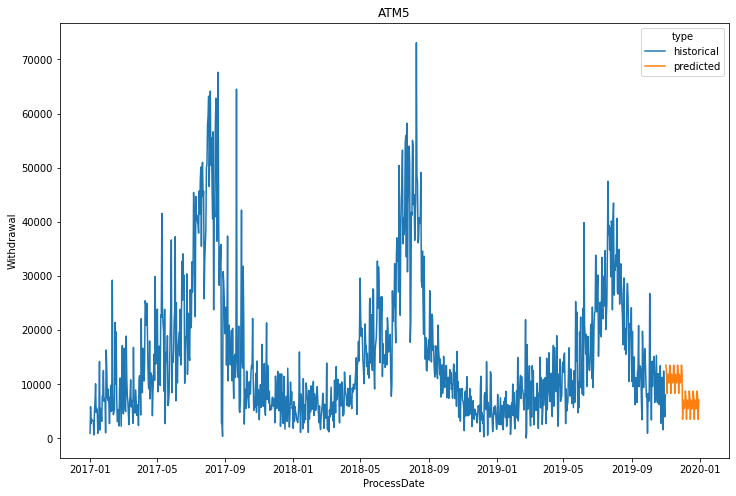

Metrics for ATM6
RMSE on test data 11527.222852330593
RMSE on train data 10988.873934131196


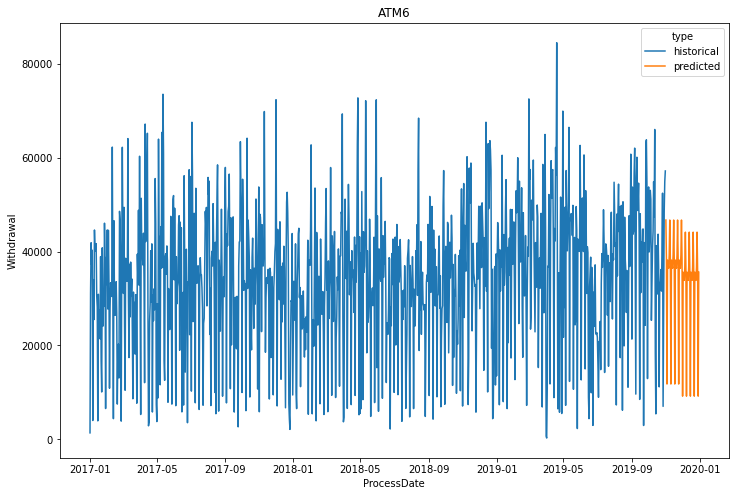

Metrics for ATM7
RMSE on test data 6248.280306372968
RMSE on train data 6930.422498872793


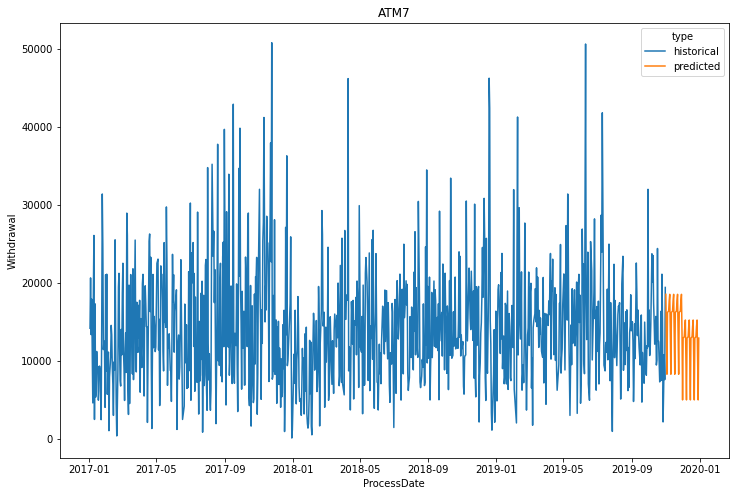

Metrics for ATM8
RMSE on test data 12248.601738495323
RMSE on train data 21373.719435084866


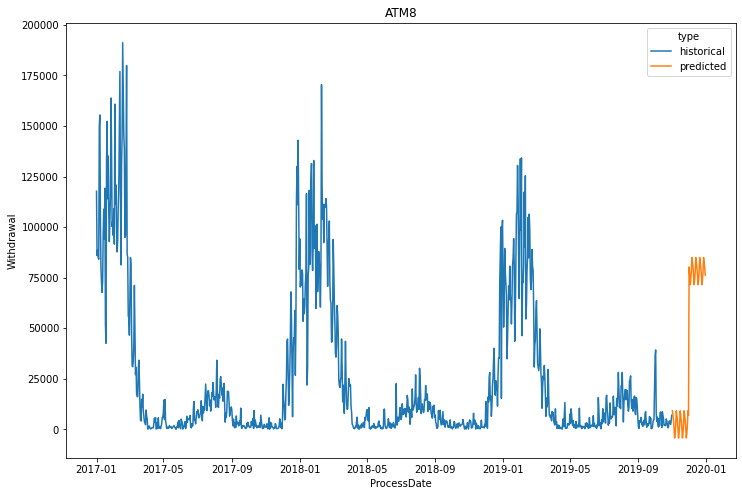

Metrics for ATM9
RMSE on test data 11285.098999004524
RMSE on train data 11516.269166946788


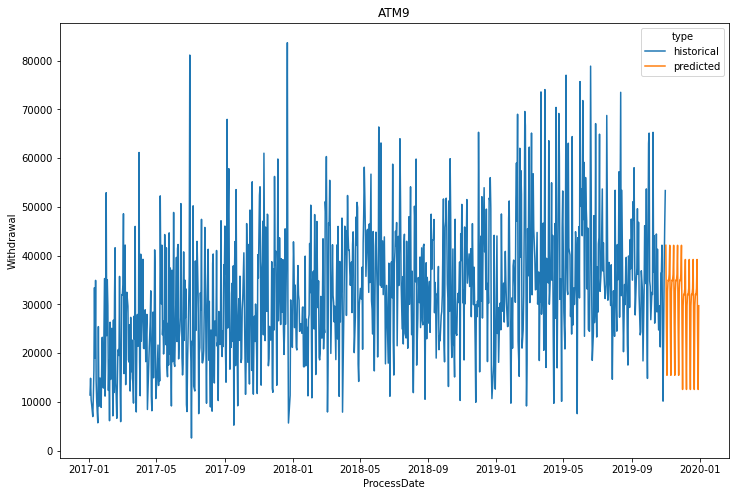

In [60]:
for i in range(1,10):
  build_model("ATM"+str(i), data)